In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the data

In [2]:
# Load the image data
images = np.load('data/ps4/ps4_trainvalid_images.npy')

# Load the labels
labels_df = pd.read_csv('data/ps4/ps4_trainvalid_labels.csv', header=0)
labels_df.columns = ['id', 'label']
labels = labels_df['label'].values

# Display basic information about the data

## Data Overview

In [3]:
# Count frequency of each label
label_counts = labels_df['label'].value_counts().sort_index()
label_meanings = {
    0: "Healthy",
    1: "Pre-existing conditions",
    2: "Effusion/Mass in lungs"
}

print("Label frequencies:")
for label, count in label_counts.items():
    meaning = label_meanings[label]
    print(f"Label {label} ({meaning}): {count} samples ({count/len(labels)*100:.2f}%)")

Label frequencies:
Label 0 (Healthy): 10506 samples (79.23%)
Label 1 (Pre-existing conditions): 2372 samples (17.89%)
Label 2 (Effusion/Mass in lungs): 382 samples (2.88%)


## Visualize the distribution

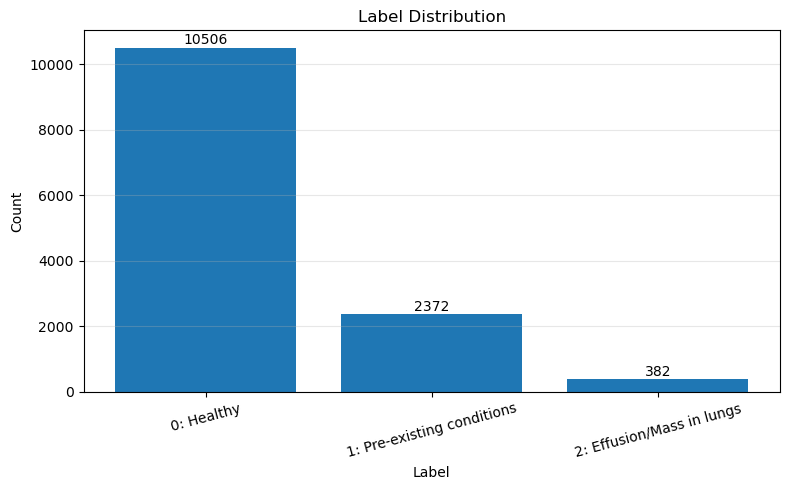


Total samples: 13260
Image data shape: (13260, 64, 64, 1)


In [4]:
plt.figure(figsize=(8, 5))
bars = plt.bar(label_counts.index.astype(str), label_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.xticks(range(len(label_meanings)),
           [f"{i}: {label_meanings[i]}" for i in sorted(label_meanings.keys())],
           rotation=15)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal samples: {len(labels)}")
print(f"Image data shape: {images.shape}")

## Visualize some images

Image shape: (64, 64, 1)


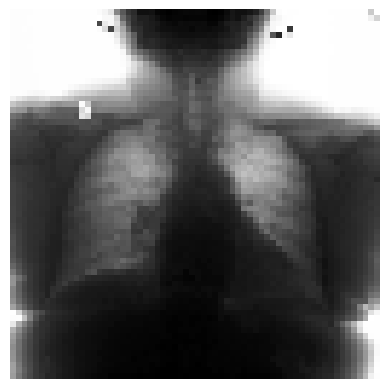

In [5]:
print(f"Image shape: {images[0].shape}")
healthy_image = images[0]
healthy_image = healthy_image.reshape(64, 64)
plt.imshow(healthy_image, cmap="binary")
plt.axis("off")
plt.show()

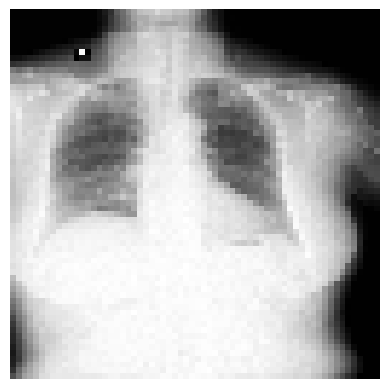

In [6]:
class_one_image = images[13]
class_one_image = class_one_image.reshape(64, 64)
plt.imshow(class_one_image, cmap="binary")
plt.axis("off")
plt.show()

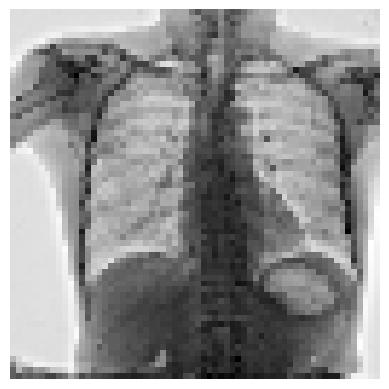

In [7]:
class_two_image = images[27]
class_two_image = class_two_image.reshape(64, 64)
plt.imshow(class_two_image, cmap="binary")
plt.axis("off")
plt.show()

# Model selection

## Preprocess the data, split into train, validation, and test sets

In [8]:
images = images.reshape(-1, 64, 64, 1)
images = images / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(np.unique(y_train)) * count) for i, count in enumerate(class_counts)}

In [9]:
def create_cnn_model(filters=(32, 64, 128), dense_units=(128,), dropout_rate=0.3):
    """
    Create a CNN model with the specified architecture.
    Args:
        filters: Tuple of integers representing the number of filters in each convolutional layer.
        dense_units: Tuple of integers representing the number of units in each dense layer.
        dropout_rate: Float representing the dropout rate.
    Returns:
        model: Compiled Keras model.
    """

    model = models.Sequential()
    model.add(layers.Conv2D(filters[0], (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    for f in filters[1:]:
        model.add(layers.Conv2D(f, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    for units in dense_units:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Create and summarize the model

In [10]:
model = create_cnn_model()
model.summary()

/opt/miniconda3/envs/deeplearning-env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-23 15:32:42.459644: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-05-23 15:32:42.459671: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-23 15:32:42.459676: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-23 15:32:42.459694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 15:32:42.459705: I tensorflow/core/common_runtime/pluggable_device/pluggable_d

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,171 (4.36 MB)

 Trainable params: 1,142,467 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

## Train the model

In [11]:
# Define callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=50, # 50 epoch was optimal
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/100


2025-05-23 15:32:43.373323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


249/249 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5246 - loss: 1.2926 - val_accuracy: 0.1286 - val_loss: 1.6892 - learning_rate: 0.0010
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6600 - loss: 0.9579 - val_accuracy: 0.6561 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6889 - loss: 0.8973 - val_accuracy: 0.6474 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7358 - loss: 0.8581 - val_accuracy: 0.7892 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7782 - loss: 0.6867 - val_accuracy: 0.7285 - val_loss: 0.7386 - learning_rate: 0.0010
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7753 - loss: 0.7102 - val_accuracy: 0.7753 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7925 - loss: 0

## Evaluate the model

In [12]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Pre-existing', 'Effusion/Mass']))

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

      Healthy       0.97      0.93      0.95      2101
 Pre-existing       0.72      0.82      0.77       475
Effusion/Mass       0.22      0.25      0.23        76

     accuracy                           0.89      2652
    macro avg       0.64      0.67      0.65      2652
 weighted avg       0.90      0.89      0.90      2652



# Plot confusion matrix

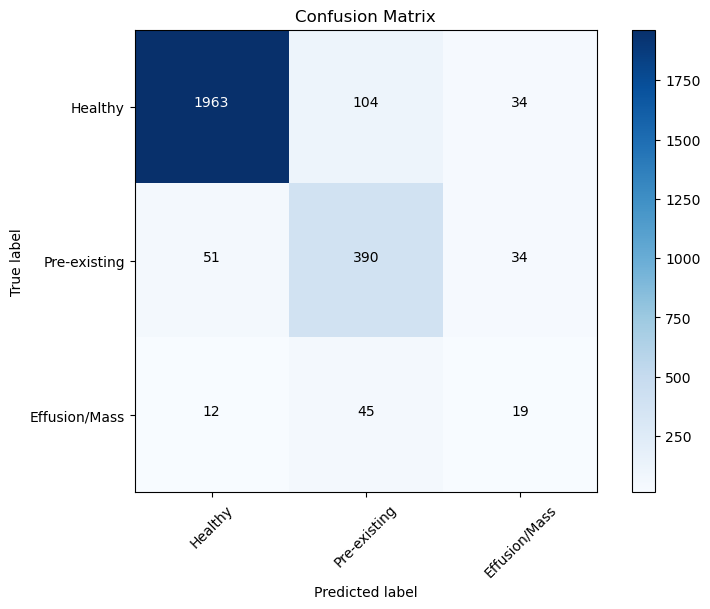

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Healthy', 'Pre-existing', 'Effusion/Mass'], rotation=45)
plt.yticks(tick_marks, ['Healthy', 'Pre-existing', 'Effusion/Mass'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# Saliency map generation

In [14]:
def occlusion_sensitivity(model, image, label, patch_size=8, stride=4):
    """
    Generate an occlusion sensitivity map for a given image and label.
    Args:
        model: Trained Keras model.
        image: Input image (64x64x1).
        label: True label of the image.
        patch_size: Size of the occlusion patch.
        stride: Stride for moving the occlusion patch.
    Returns:
        sensitivity_map: Occlusion sensitivity map.
    """

    orig_image = image.reshape(1, 64, 64, 1)
    orig_pred = model.predict(orig_image)[0, label]

    sensitivity_map = np.zeros((64, 64))
    patch = np.ones((patch_size, patch_size)) * 0.5

    for i in range(0, 64 - patch_size + 1, stride):
        for j in range(0, 64 - patch_size + 1, stride):
            occluded_image = image.copy()
            occluded_image[i:i+patch_size, j:j+patch_size, 0] = patch

            occluded_pred = model.predict(occluded_image.reshape(1, 64, 64, 1))[0, label]

            sensitivity = orig_pred - occluded_pred
            sensitivity_map[i:i+patch_size, j:j+patch_size] += sensitivity

    return sensitivity_map

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

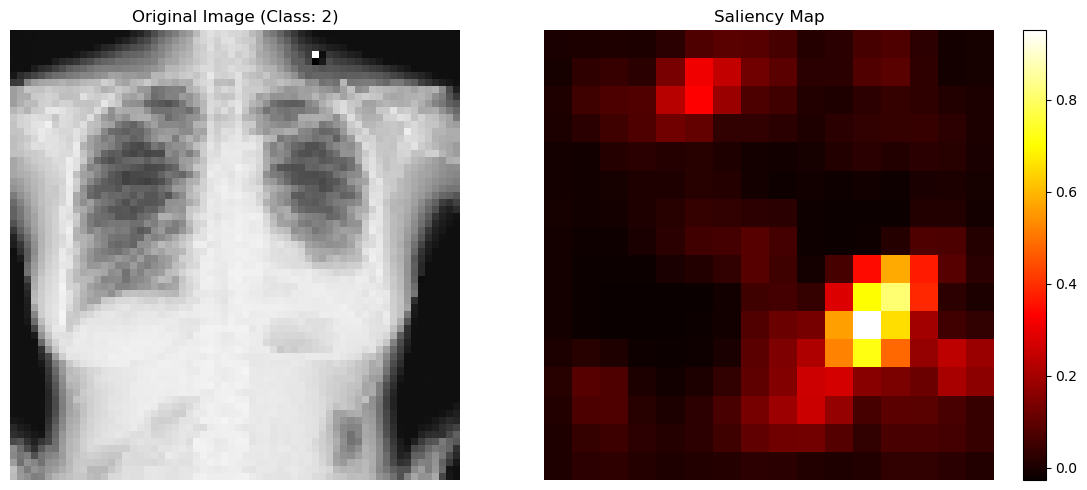

In [15]:
class2_indices = np.where((y_test == 2) & (y_pred == 2))[0]

if len(class2_indices) > 0:
    sample_idx = class2_indices[0]
    sample_image = X_test[sample_idx]
    sample_label = y_test[sample_idx]

    saliency_map = occlusion_sensitivity(model, sample_image, sample_label)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(sample_image.reshape(64, 64), cmap='binary')
    plt.title(f'Original Image (Class: {sample_label})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Kaggle submission

In [17]:
kaggle_images = np.load('data/ps4/ps4_kaggle_images.npy')

kaggle_images = kaggle_images.reshape(-1, 64, 64, 1)
kaggle_images = kaggle_images / 255.0

predictions_prob = model.predict(kaggle_images)
predictions = np.argmax(predictions_prob, axis=1)

submission_df = pd.DataFrame({
    'Id': range(len(predictions)),
    'Predicted': predictions
})

submission_df.to_csv('kaggle_submission.csv', index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
